<a href="https://colab.research.google.com/github/sdhar2020/Elastic-Net-Regression/blob/master/Ames_Iowa_Housing_Price_Prediction_D2_0_03102020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement
The Ames Iowa Housing Price Data Set is a benchmark data set used as a typical ssignmet in multivariate regression class pedagogy. In fact there was a Kaggle challenge 2 years back that used a version of the data.

# Libraries & Settings

In [ ]:
import pandas as pd
pd.options.display.max_columns = 999
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV

# The real McCoy

Instead of using the Kaggle data I choose to use the data from the original publication of Dean DeCock. This data doesn't have the missing value challenge in the kaggle data set and come with a handy data dictionary which helps in understanding of relationships and also the type of data fields

In [ ]:
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',sep= '\t', header= 'infer', index_col='PID')

In [ ]:
#@title Default title text
df.isnull().sum().sort_values(ascending= False)*100/len(df)

Pool QC           99.556314
Misc Feature      96.382253
Alley             93.242321
Fence             80.477816
Fireplace Qu      48.532423
                    ...    
2nd Flr SF         0.000000
1st Flr SF         0.000000
Central Air        0.000000
Sale Condition     0.000000
Order              0.000000
Length: 81, dtype: float64

# Time Treatment
Tenurizing the time frames into age etc

In [ ]:
time_cols= ['Mo Sold', 'Yr Sold','Year Built', 'Year Remod/Add']

In [ ]:
def treat_time(df, time_Cols):
  df['sale_age']= (df['Yr Sold']- df['Year Built']).clip(lower= 0) # Age at sale. clips any -ve value to 0
  df['remod_age']= (df['Yr Sold']- df['Year Remod/Add']).clip(lower=0) # age of remodeling/add at sale. clips any value at 0
  df['sale_yrmo']= df['Yr Sold']*10000+ df['Mo Sold']*100 # Single year-month index for sorting in order to preserve causality
  df['sin_sale_mo']= np.sin(2*np.pi*df['Mo Sold']/12) # Sine term to capture any seasonality of month
  df['cos_sale_mo']= np.cos(2*np.pi*df['Mo Sold']/12) # Cosine term to capture any seasonality of month
  df.sort_values('sale_yrmo', inplace=True) # Sorting from earliest to lowest in order to preserve causality
  df.drop(time_cols, axis=1, inplace=True)
  return(df)

In [ ]:
df = treat_time(df, time_cols)

In [ ]:
time_features = ['sale_age','remod_age','sale_yrmo','sin_sale_mo','cos_sale_mo']

#Null treatment

Dropping data columns with more than 5% Null values and imputing the rest
- Median for numerics
- Non Null Mode values for Strings/ Characters

In [ ]:
def null_treat(df, threshold= 5.00):
  df= df.copy(deep=True)
  nul_vals= 100*df.isnull().sum()/len(df)
  incl_cols = nul_vals[nul_vals <= threshold]
  incl_cols = incl_cols.index.tolist()
  excl_cols = list(set(df.columns) - set(incl_cols))
  df = df[incl_cols]
  num_fil= df.select_dtypes(include= ['int64','float64']).median().to_dict()
  obj_fil= df.select_dtypes(include= ['object']).mode(dropna= True).iloc[0].to_dict()
  df.fillna(value=num_fil, inplace= True)
  df.fillna(value=obj_fil, inplace= True)
  return(excl_cols,incl_cols, df)

In [ ]:
excl_cols,incl_cols, df1= null_treat(df)

In [ ]:
num_cols= df1.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df1.select_dtypes(include=['object']).columns.tolist()

## Ordinal Variable Treatment

Variables that are characters but have a order of precedence/ priority or various shades of bad/ good for instance poor to excellent

In [ ]:
def ordinal_map(df):
  df= df.copy(deep=True)
  df['Lot Shape']= df['Lot Shape'].map({'Reg':4, 'IR1':3,'IR2':2,'IR3':1}, na_action= 0)
  df['Utilities']= df['Utilities'].map({'AllPub':1, 'NoSewr':0,'NoSeWa':0,'ELO':0}, na_action= 0)
  df['Land Slope']= df['Land Slope'].map({'Gtl':3,'Mod':2,'Sev':1}, na_action=0)
  df['Exter Qual']= df['Exter Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}, na_action= 0)
  df['Exter Cond']= df['Exter Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}, na_action= 0)
  df['Bsmt Qual']= df['Bsmt Qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}, na_action= 0)
  df['Bsmt Cond']= df['Bsmt Cond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}, na_action= 0)
  df['Bsmt Exposure']= df['Bsmt Exposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0}, na_action=0)
  df['BsmtFin Type 1']= df['BsmtFin Type 1'].map({'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2, 'Rec': 3, 'Unf': 1,'NA':0}, na_action=0)
  df['BsmtFin Type 2']= df['BsmtFin Type 2'].map({'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2, 'Rec': 3, 'Unf': 1,'NA':0}, na_action=0)
  df['Heating QC']= df['Heating QC'].map({'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3}, na_action=0)
  df['Electrical']= df['Electrical'].map({'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1, 'SBrkr': 5}, na_action= 0)
  df['Kitchen Qual']= df['Kitchen Qual'].map({'Ex': 5, 'Fa': 3, 'Gd': 4, 'Po': 1, 'TA': 2}, na_action=0)
  df['Functional']= df['Functional'].map({'Maj1': 4,'Maj2': 3,'Min1': 7,'Min2': 6,'Mod': 5,'Sal': 1,'Sev': 2,'Typ': 8}, na_action= 0)
  # df['Fireplace Qu']= df['Fireplace Qu'].map({'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3, 'NA':0}, na_action=0)
  # df['Garage Finish']= df['Garage Finish'].map({'Fin': 3, 'RFn': 2.0, 'Unf': 1, 'NA':0}, na_action=0)
  # df['Garage Qual']= df['Garage Qual'].map({'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3, 'NA':0}, na_action=0)
  # df['Garage Cond']= df['Garage Cond'].map({'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1, 'TA': 3, 'NA':0}, na_action=0)
  df['Paved Drive']= df['Paved Drive'].map({'N': 1, 'P': 2, 'Y': 3},na_action=0)
  # df['Pool QC']= df['Pool QC'].map({'Ex': 3.5, 'Fa': 1.0, 'Gd': 3.5, 'TA': 2.0}, na_action=0)
  # df['Fence']= df['Fence'].map({'GdPrv': 4, 'GdWo': 2, 'MnPrv': 3, 'MnWw': 1.0, 'NA':0},na_action=0)
  return(df)

In [ ]:
ordinal_cols= ['Lot Shape', 'Utilities', 'Land Slope','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond', \
               'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC','Electrical','Kitchen Qual',\
               'Functional','Paved Drive']

In [ ]:
df2= ordinal_map(df1)

In [ ]:
cat_cols = list(set(cat_cols)- set(ordinal_cols))

# Nominal Variables

Convert to Dummy variables


In [ ]:
def nominal_var_treat(df):
  nominal_columns= df.select_dtypes(include='object').columns.tolist()
  dummy_df = pd.get_dummies(df[nominal_columns])
  dummy_cols = dummy_df.columns.tolist()
  df1 = pd.concat([df, dummy_df], axis=1)
  df1= df1.drop(nominal_columns, axis=1)
  return(nominal_columns, dummy_cols, df1)

In [ ]:
nominal_cols, dummy_cols, df3= nominal_var_treat(df2)

In [ ]:
set(cat_cols)- set(nominal_cols)

set()

# Outliers

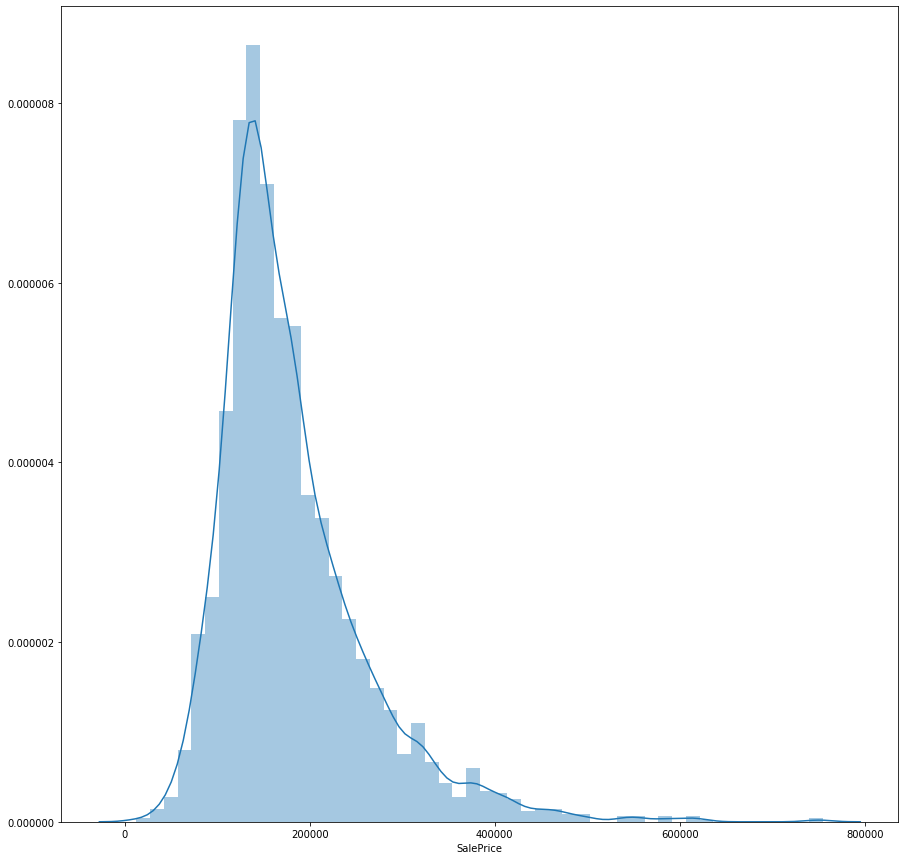

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
sns.distplot(df3['SalePrice'], ax=ax)

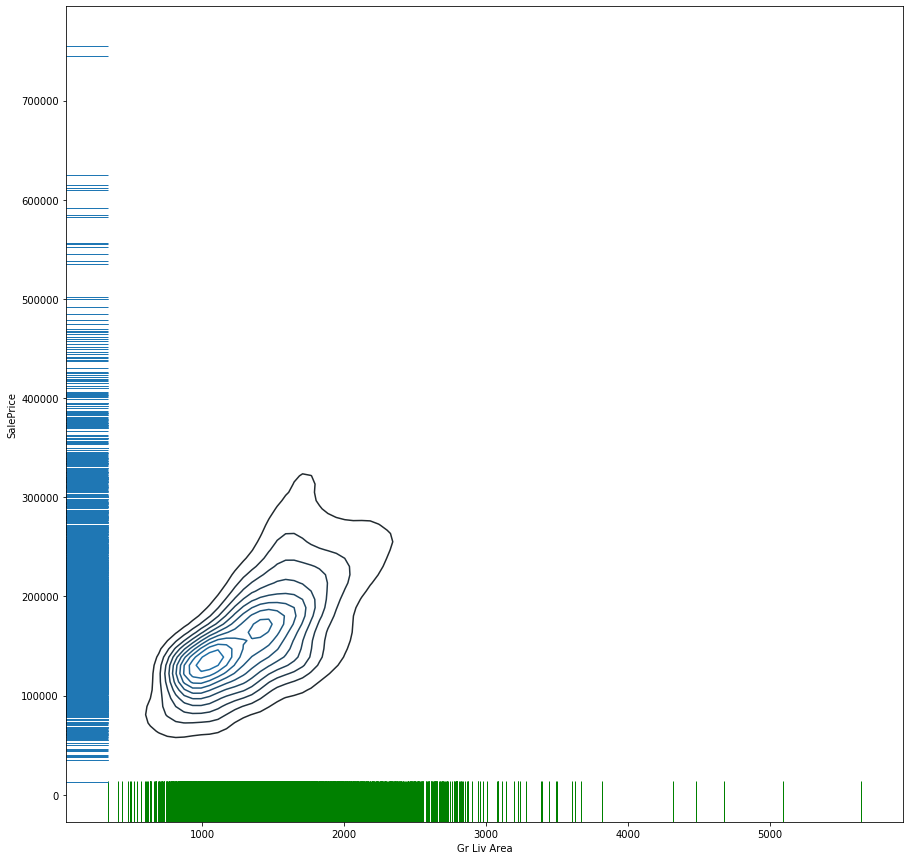

In [ ]:
# g = sns.jointplot(x='Gr Liv Area', y='SalePrice', data=df3, kind="kde", color='k')
f, ax = plt.subplots(figsize=(15, 15))
sns.kdeplot(df3['Gr Liv Area'], df3['SalePrice'], ax=ax)
sns.rugplot(df3['Gr Liv Area'], color="g", ax=ax)
sns.rugplot(df3['SalePrice'], vertical=True, ax=ax);

There are outliers beyond 4000 above grade (ground) living area square feet. Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). Removing all of these

In [ ]:
df4= df3[df3['Gr Liv Area'] <= 4000]

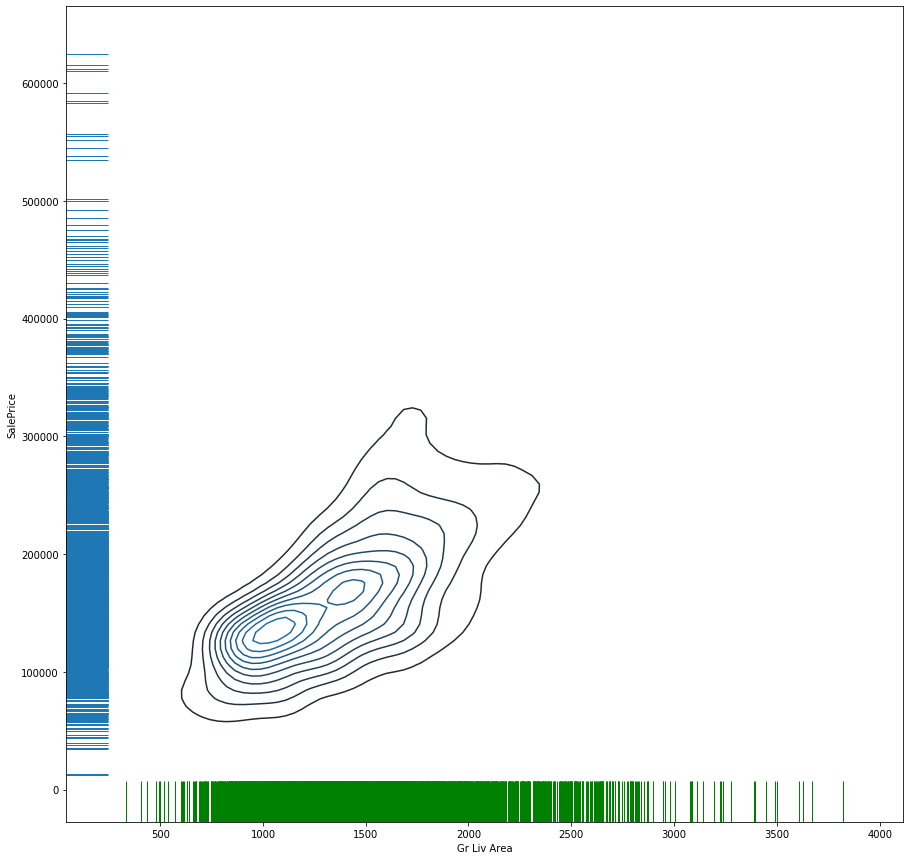

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
sns.kdeplot(df4['Gr Liv Area'], df4['SalePrice'], ax=ax)
sns.rugplot(df4['Gr Liv Area'], color="g", ax=ax)
sns.rugplot(df4['SalePrice'], vertical=True, ax=ax);

# SF Area variables

There are a number of SF area variables which may nor may not be correlated.

Colinearity is the state where two variables are highly correlated and contain similiar information about the variance within a given dataset. To detect colinearity among variables, simply create a correlation matrix and find variables with large absolute values.

Multicolinearity on the other hand is more troublesome to detect because it emerges when three or more variables, which are highly correlated, are included within a model. To make matters worst multicolinearity can emerge even when isolated pairs of variables are not colinear.

In this step we shall buid a function to examine the multicolinearity between SF variables and use causality information to reduce the variable set.

In [ ]:
sf_cols =['BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Wood Deck SF',
 'Open Porch SF',
 'Gr Liv Area',
 'Garage Area',
 '3Ssn Porch',
 'Enclosed Porch',
 'Pool Area',
 'Lot Area',
 'Mas Vnr Area']

In [ ]:
def vif_calc(df4, vif_cols):
  vif = pd.DataFrame()
  vif['features']= sf_cols
  vif['vif'] =[variance_inflation_factor(df4[sf_cols].replace(0,1).values, i) for i in range(df4[sf_cols].shape[1])]
  vif.sort_values('vif', ascending=False, inplace=True)
  return(vif)

In [ ]:
vif= vif_calc(df4, sf_cols)

In [ ]:
sf_cols.remove('Gr Liv Area')
sf_cols.remove('Total Bsmt SF')

In [ ]:
vif2= vif_calc(df4, sf_cols)

In [ ]:
sf_cols.remove('1st Flr SF')

In [ ]:
vif3 = vif_calc(df4, sf_cols)

In [ ]:
sf_cols.remove('Garage Area')

In [ ]:
vif4 = vif_calc(df4, sf_cols)

In [ ]:
hi_vif = {'Gr Liv Area', 'Total Bsmt SF','Total Bsmt SF','Total Bsmt SF'}

# Prediction Variable List


In [ ]:
for h in hi_vif:
  num_cols.remove(h)

In [ ]:
all_features = dummy_cols+ordinal_cols+num_cols

In [ ]:
y = df4['SalePrice'].values

In [ ]:
all_features.remove('SalePrice')

In [ ]:
X= df4[all_features].values

# Model Build Harness


In [ ]:
#  from sklearn.datasets import make_regression
#  X, y = make_regression(n_features=2, random_state=0)

In [ ]:
regr = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, .99, 1], \
                    fit_intercept= True, normalize= True, \
                    alphas= [1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
                    1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06], max_iter=100000, verbose= True)


In [ ]:
regr.fit(X, y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
................................................................................................................................................................................................................................................................................................................................................./usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2554375224.196167, tolerance: 1415549569.2091925
  tol, rng, random, positive)
............./usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5539690017.790649, tolerance: 1472509226.7485247
  tol, rng, random, positive)
.......

ElasticNetCV(alphas=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                     1000.0, 10000.0, 100000.0, 1000000.0],
             copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000,
             n_alphas=100, n_jobs=None, normalize=True, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=True)

In [ ]:
yhat= regr.predict(X)

In [ ]:
regr.score(X,y)

0.9213864268357914

In [ ]:
mse = mean_squared_error(y, yhat)
rmse = np.sqrt(mse)

In [ ]:
print(mse, rmse)

484947943.7138292 22021.533636734504


Text(0.5, 1.0, 'y=0.904203x+17282.871916')

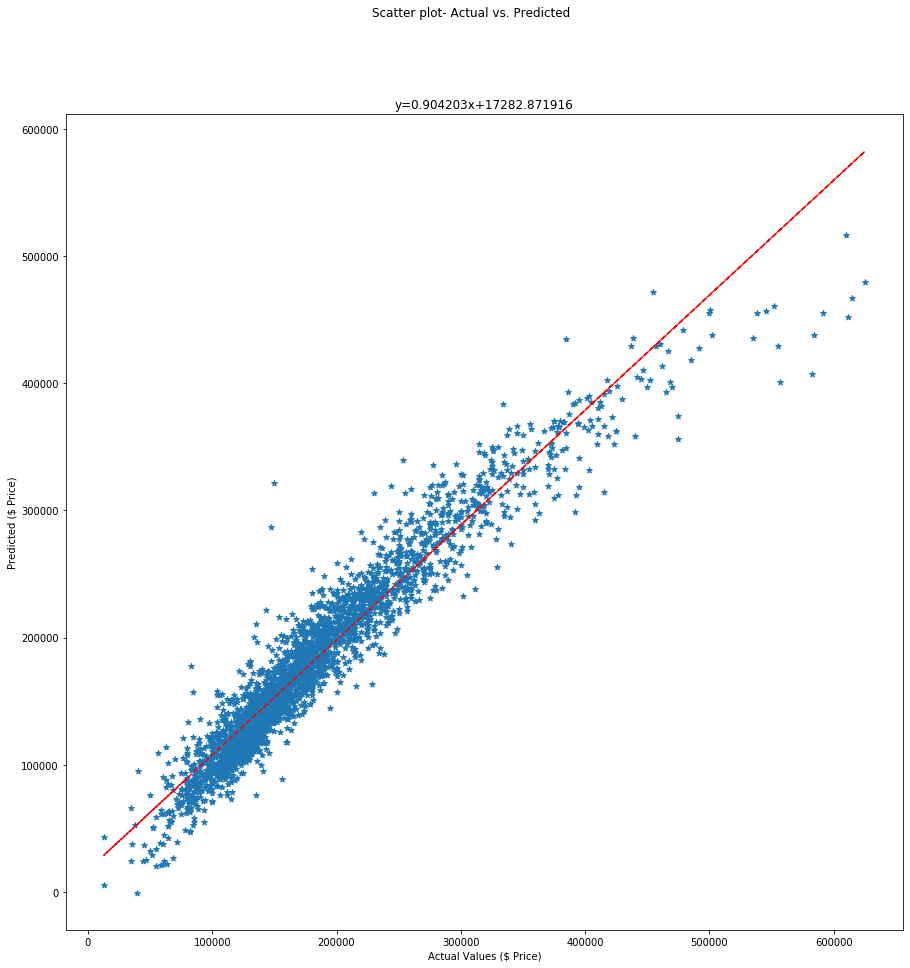

In [ ]:
plt.figure(figsize=(15,15))
plt.suptitle('Scatter plot- Actual vs. Predicted')
plt.xlabel('Actual Values ($ Price)')
plt.ylabel('Predicted ($ Price)')
plt.scatter(y,yhat, marker= '*')
z = np.polyfit(y, yhat, 1)
p = np.poly1d(z)
plt.plot(y,p(y),"r--")
plt.title("y=%.6fx+%.6f"%(z[0],z[1]))

# Interaction Variables (TBD)



In [ ]:
poly = PolynomialFeatures(degree= 2, interaction_only=True)

In [ ]:
p= poly.fit_transform(df4.values)

In [ ]:
p.shape

(2925, 22156)

In [ ]:
import http.client

conn = http.client.HTTPSConnection("urban-algorithmics-geo-data-v1.p.rapidapi.com")

headers = {
    'x-rapidapi-host': "urban-algorithmics-geo-data-v1.p.rapidapi.com",
    'x-rapidapi-key': "SIGN-UP-FOR-KEY"
    }

conn.request("GET", "/all", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"message":"Invalid X-Rapidapi-Key"}


# Crime API